In [ ]:
import os
import torch
import numpy as np
from google.colab import drive
import re
import torchvision
import pandas as pd
import cv2
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shareddrives/Strawberries/Image experiment')

embedding_size = 16

Mounted at /content/drive


In [ ]:
# Function to convert a tensor to an image
def to_img(x):
    return np.moveaxis(x.numpy() * 255, 0, -1).astype(np.uint8)

# Function to get the length-to-width ratio of the largest contour in an image
def getLWR(img):
    # Convert image to grayscale if it has more than one channel
    if img.shape[2] > 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Add a constant border to the image
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=0)
    # Apply binary thresholding
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invert image if the background is white
    if img[0, 0] == 255:
        img = cv2.bitwise_not(img)
    # Find contours in the image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest contour by area
    contour = max(contours, key=cv2.contourArea)
    # Get dimensions of the minimum area rectangle enclosing the contour
    w, h = cv2.minAreaRect(contour)[1]
    # Return the length-to-width ratio
    return max(w, h) / min(w, h)

def getShapeIndex(img):
      # Convert image to grayscale if it has more than one channel
    if img.shape[2] > 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Add a constant border to the image
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=0)
    # Apply binary thresholding
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invert image if the background is white
    if img[0, 0] == 255:
        img = cv2.bitwise_not(img)
    # Find contours in the image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest contour by area
    contour = max(contours, key=cv2.contourArea)
    # Initialize variables to store the max width and corresponding height
    max_width = 0
    max_height = 0
    point1 = None
    point2 = None
    # Iterate through each pair of points in the contour
    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            # Calculate the distance between the two points in both x and y directions
            dx = contour[j][0][0] - contour[i][0][0]
            dy = contour[j][0][1] - contour[i][0][1]
            # If the distance in the x direction (width) is the largest we've seen
            width = abs(dx)
            if width > max_width:
                max_width = width
                max_height = abs(dy)  # The corresponding height (vertical distance)
                point1 = contour[i][0]
                point2 = contour[j][0]
    return max_height / max_width

def getMeanNonBlackColor(img):
  data = img.reshape(-1, img.shape[-1])
  data = data[np.array([np.all(i != [0,0,0]) for i in data])]
  return np.mean(data, axis = 0)

def getRedness(img):
  # image should be rgb
  data = img.reshape(-1, img.shape[-1])
  data = data[np.array([np.all(i != [0,0,0]) for i in data])]
  # redness is distance from (160,20,20)
  distances = np.linalg.norm(data - [160,20,20], axis = 1)
  distances = 255 - np.mean(distances)
  return distances

# Hyperparameters
image_size = (100, 100, 3)  # Dimensions of input images (height, width, channels)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(np.prod(image_size), 400)  # Input layer to hidden layer
        self.fc21 = nn.Linear(400, embedding_size)  # Hidden layer to mean of latent space
        self.fc22 = nn.Linear(400, embedding_size)  # Hidden layer to log variance of latent space
        self.fc3 = nn.Linear(embedding_size, 400)  # Latent space to hidden layer
        self.fc4 = nn.Linear(400, np.prod(image_size))  # Hidden layer to output layer

    # Encode function to obtain mean and log variance of the latent space
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # Reparametrization trick to sample from the latent space
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()  # Compute standard deviation
        # Generate random noise
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)  # Return the sampled latent vector

    # Decode function to reconstruct the image from the latent vector
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # Forward pass through the VAE
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

def take_mean(df, accessions):
    df = pd.DataFrame(df)
    df['Accession'] = accessions
    df_grouped = df.groupby('Accession').mean()  # Automatically handles NaN with .mean()
    return df_grouped.reset_index(drop=True) # Reset index and drop the Accession column

images = torch.load('fullImages.pt')

In [ ]:
for random_seed in list(range(1,50)):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = VAE()
  model.to(device)
  model.load_state_dict(torch.load(str(random_seed) + "_vae_" + str(embedding_size) + ".pth", map_location=torch.device('cpu')))

  print(random_seed)

  trainKey = np.genfromtxt(f"{random_seed}_trainKey.csv", delimiter=',', skip_header=0)
  testKey = np.genfromtxt(f"{random_seed}_testKey.csv", delimiter=',', skip_header=0)
  phenotypes = pd.read_csv("fullPhenotypes.csv")
  rrBLUPpredictedTraits = pd.read_csv(str(random_seed) + '_rrBLUPpredictedTraits' + '.csv')

  accessions = trainKey.copy()
  accessions[testKey >= 0] = testKey[testKey >= 0]

  trainKey = take_mean(trainKey, accessions).to_numpy().flatten()
  testKey = take_mean(testKey, accessions).to_numpy().flatten()
  phenotypes = take_mean(phenotypes, accessions)
  rrBLUPpredictedTraits = take_mean(rrBLUPpredictedTraits, accessions)

  trainKey = trainKey >= 0
  testKey = testKey >= 0

  rrBLUPPredictedEmbeddings = torch.tensor(pd.read_csv(str(random_seed) + '_rrBLUPpredictedEmbeddings_' + str(embedding_size) + '.csv').to_numpy(), dtype = torch.float32)
  endToEndLWRs = []
  endToEndShapeIndices = []
  endToEndBs = []
  endToEndGs = []
  endToEndRs = []
  endToEndRednesses = []
  endToEndImages = []
  endToEndRandoms = []

  for i in range(len(rrBLUPPredictedEmbeddings)):
    # print(str(i) + ' out of ' + str(len(rrBLUPPredictedEmbeddings)))
    rrBLUPPredictedEmbedding = rrBLUPPredictedEmbeddings[i,:]
    # predictedEmbedding = torch.tensor(np.random.normal(size=test_loader.dataset.tensors[1][i].shape).astype(np.float32))
    # predictedEmbedding = test_loader.dataset.tensors[1][i]
    endToEndImage = model.decode(rrBLUPPredictedEmbedding.to(device))
    endToEndImage = endToEndImage.view(1, -1)
    endToEndImage = to_img(endToEndImage.cpu().detach().view(image_size[::-1]))
    # plt.figure()
    # plt.imshow(cv2.cvtColor(endToEndImage,  cv2.COLOR_BGR2RGB))
    # plt.pause(0.0001)
    endToEndLWR = getLWR(endToEndImage)
    endToEndLWRs.append(endToEndLWR)
    endToEndShapeIndex = getShapeIndex(endToEndImage)
    endToEndShapeIndices.append(endToEndShapeIndex)
    endToEndB, endToEndG, endToEndR = getMeanNonBlackColor(cv2.cvtColor(endToEndImage,  cv2.COLOR_BGR2RGB))
    endToEndBs.append(endToEndB)
    endToEndGs.append(endToEndG)
    endToEndRs.append(endToEndR)
    endToEndRedness = getRedness(cv2.cvtColor(endToEndImage,  cv2.COLOR_BGR2RGB))
    endToEndRednesses.append(endToEndRedness)
    endToEndRandoms.append(np.random.normal(size=1)[0])
    endToEndImages.append(endToEndImage)

  torch.save(endToEndImages, str(random_seed) + '_endToEndImages.pt')

  endToEndLWRs = np.array(endToEndLWRs)
  endToEndShapeIndices = np.array(endToEndShapeIndices)
  endToEndBs = np.array(endToEndBs)
  endToEndGs = np.array(endToEndGs)
  endToEndRs = np.array(endToEndRs)
  endToEndRednesses = np.array(endToEndRednesses)
  endToEndRandoms = np.array(endToEndRandoms)
  endToEndPhenotypes = phenotypes * 0
  endToEndPhenotypes['LWR'] = endToEndLWRs
  endToEndPhenotypes['ShapeIndex'] = endToEndShapeIndices
  endToEndPhenotypes['B'] = endToEndBs
  endToEndPhenotypes['G'] = endToEndGs
  endToEndPhenotypes['R'] = endToEndRs
  endToEndPhenotypes['Redness'] = endToEndRednesses
  endToEndPhenotypes['Random'] = endToEndRandoms

  for trait in phenotypes.columns.values:
    print(trait)
    traditionalTestAccuracy = np.corrcoef(rrBLUPpredictedTraits[trait].values[testKey], phenotypes[trait].values[testKey])[0,1] ** 2
    endToEndTestAccuracy = np.corrcoef(endToEndPhenotypes[trait].values[testKey], phenotypes[trait].values[testKey])[0,1] ** 2
    print(traditionalTestAccuracy)
    print(endToEndTestAccuracy)
    print(endToEndTestAccuracy / traditionalTestAccuracy)

    df = pd.DataFrame(np.concatenate([endToEndPhenotypes[trait].values[testKey], rrBLUPpredictedTraits[trait].values[testKey]]), columns = ['predicted'])
    df['method'] = np.concatenate([np.repeat('end-to-end', len(endToEndPhenotypes[trait].values[testKey])), np.repeat('traditional', len(rrBLUPpredictedTraits[trait].values[testKey]))])
    df['known'] = np.concatenate([phenotypes[trait].values[testKey], phenotypes[trait].values[testKey]])
    fig = px.scatter(df, x = 'predicted', y = 'known', color = 'method', title = trait)
    fig.add_trace(go.Scatter(
        x=[np.min(phenotypes[trait].values[testKey]), np.max(phenotypes[trait].values[testKey])],
        y=[np.min(phenotypes[trait].values[testKey]), np.max(phenotypes[trait].values[testKey])],
        name = 'predicted = known',
    ))
    fig.show()

    # save df as csv
    # df.to_csv(str(random_seed) + '_' + trait + '_correlations.csv', index = False)

In [ ]:
allFlattenedImages = np.array([to_img(i).flatten() for i in images])

for random_seed in list(range(1,50)):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = VAE()
  model.to(device)
  model.load_state_dict(torch.load(str(random_seed) + "_vae_" + str(embedding_size) + ".pth", map_location=torch.device('cpu')))

  embeddings = torch.load(str(random_seed) + "_embeddings_" + str(embedding_size) + ".pt")

  trainKey = np.genfromtxt(f"{random_seed}_trainKey.csv", delimiter=',', skip_header=0)
  testKey = np.genfromtxt(f"{random_seed}_testKey.csv", delimiter=',', skip_header=0)
  phenotypes = pd.read_csv("fullPhenotypes.csv")
  rrBLUPpredictedTraits = pd.read_csv(str(random_seed) + '_rrBLUPpredictedTraits' + '.csv')

  accessions = trainKey.copy()
  accessions[testKey >= 0] = testKey[testKey >= 0]

  trainKey = take_mean(trainKey, accessions).to_numpy().flatten()
  testKey = take_mean(testKey, accessions).to_numpy().flatten()

  trainKey = trainKey >= 0
  testKey = testKey >= 0

  all_cors = []
  all_randomCors = []
  endToEndImages = np.array(torch.load(str(random_seed) + '_endToEndImages.pt', weights_only = False))
  improvements = []
  for i in np.where(testKey)[0]:
      theseImages = images[accessions == i]
      theseEmbeddings = embeddings[accessions == i]
      theseImages = [model.decode(i.to(device)).view(1,-1).cpu().detach().view(image_size[::-1]) for i in theseEmbeddings]

      n_images = len(theseImages) + 1
      side_length = int(np.ceil(np.sqrt(n_images)))
      side_length = 6
      mosaic_size = side_length * 100
      mosaic = np.zeros((mosaic_size, mosaic_size, 3), dtype=np.uint8)

      distances = []
      cors = []
      randomDistances = []
      randomCors = []
      for j in range(side_length ** 2):

          thisEndToEndImage = endToEndImages[i]
          thisRandomImage = endToEndImages[np.random.randint(len(endToEndImages))]
          # thisRandomImage = to_img(images[np.random.randint(len(images))])

          x = (j % side_length) * 100
          y = (j // side_length) * 100

          if (j >= len(theseImages)) or (j >= (side_length ** 2) - 1):
            thisImage = thisEndToEndImage
          else:
            thisImage = to_img(theseImages[j])
            # get euclidean distance between theseImages[j] and thisEndToEndImage
            # distance = np.linalg.norm(thisImage.flatten() - thisEndToEndImage.flatten())
            distance = np.mean((thisImage.flatten() - thisEndToEndImage.flatten()) ** 2)
            distances.append(distance)
            cor = np.corrcoef(thisImage.flatten(), thisEndToEndImage.flatten())[0, 1] ** 2
            cors.append(cor)
            # randomDistance = np.linalg.norm(thisImage.flatten() - thisRandomImage.flatten())
            randomDistance = np.mean((thisImage.flatten() - thisRandomImage.flatten()) ** 2)
            # randomDistance = np.array(([np.mean((thisImage.flatten() - thisRandomImage) ** 2) for thisRandomImage in allFlattenedImages]))
            randomDistances.append(randomDistance)
            randomCor = np.corrcoef(thisImage.flatten(), thisRandomImage.flatten())[0, 1] ** 2
            randomCors.append(randomCor)

          mosaic[y:y+100, x:x+100, :] = thisImage

      improvements.append(np.mean(distances) - np.mean(randomDistances))
      all_cors.append(np.mean(cors))
      all_randomCors.append(np.mean(randomCors))
      # plt.figure(figsize=(10,10))
      # plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
      # message = str(np.round(np.mean(distances), 2)) + ", " + str(np.round(np.std(distances), 2)) + "; " + str(np.round(np.mean(randomDistances), 2)) + ", " + str(np.round(np.std(randomDistances), 2))
      # plt.title(message)
      # plt.pause(0.0001)
  break

In [ ]:
print(np.mean(cors))
np.mean(randomCors)

0.8524091553651686


np.float64(0.7978905230703055)

array([[[1, 1, 0],
        [1, 2, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [2, 1, 2],
        [1, 2, 2]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 0],
        [1, 1, 2],
        [2, 2, 1],
        ...,
        [1, 0, 1],
        [2, 1, 1],
        [1, 2, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 2],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 2]],

       [[1, 1, 2],
        [1, 2, 1],
        [1, 2, 1],
        ...,
        [1, 1, 2],
        [1, 1, 1],
        [1, 2, 2]],

       [[1, 1, 1],
        [1, 2, 1],
        [2, 2, 2],
        ...,
        [2, 1, 2],
        [1, 2, 1],
        [1, 1, 1]]], dtype=uint8)
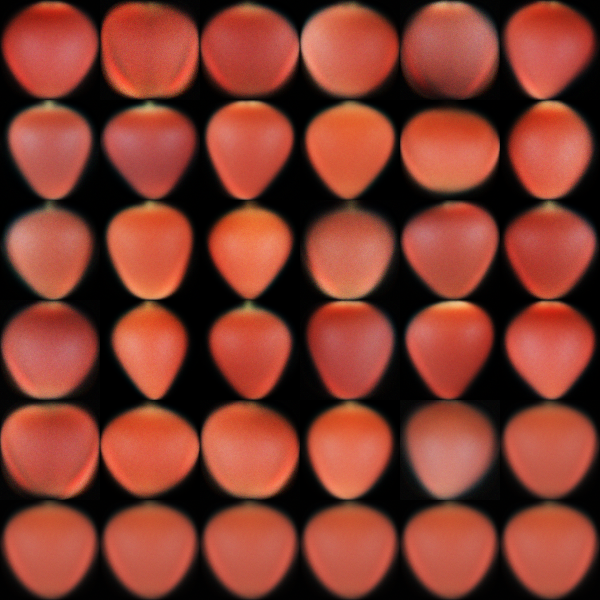

In [ ]:
mosaic[:,:,::-1]

In [ ]:
# prompt: make plotly histogram of distances and randomDistances, where they are in the same plot byt distinguished by color, small bin size

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=distances, name='Distances', nbinsx=10))
fig.add_trace(go.Histogram(x=randomDistances, name='Random Distances', nbinsx=10))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()
